In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
path='/kaggle/input/plant-pathology-2020-fgvc7/'

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
n_train = 1820

In [4]:
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv')

print('Training DataFrame:\n', train_df.head())
print('\nTest DataFrame:\n', test_df.head())

Training DataFrame:
   image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

Test DataFrame:
   image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4


In [5]:
X = []
y = []

for i in tqdm(range(n_train+1)):
    img = cv2.imread(path+'images/Train_'+str(i)+'.jpg')
    img = cv2.resize(img, (150, 150))
    X.append(img)
    X.append(cv2.flip(img, 0))
    l = train_df.iloc[i][['healthy', 'multiple_diseases', 'rust', 'scab']].to_list()
    y.append(np.array(l))
    y.append(np.array(l))    
X = np.array(X) / 255
y = np.array(y)
    


100%|██████████| 1821/1821 [01:06<00:00, 27.22it/s]


In [6]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.20)

### To handle imbalance in dataset, SMOTE is used

In [7]:
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


In [8]:
sm = SMOTE(random_state=42)

In [9]:
X_train, y_train = sm.fit_resample(X_train.reshape((-1, 150 * 150 * 3)), y_train)
X_train = X_train.reshape((-1, 150, 150, 3))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import *
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [11]:
classifier = Sequential()
classifier.add(Conv2D(64, (5, 5), input_shape = (150, 150, 3), activation = 'relu', strides=(1,1),))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(64, (5, 5), activation = 'relu', strides=(1,1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(64, (5, 5), activation = 'relu', strides=(1,1), padding='SAME'))
classifier.add(MaxPooling2D(pool_size = (4, 4)))
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides=(1, 1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides=(1, 1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides=(1, 1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(MaxPooling2D(pool_size = (3, 3)))
classifier.add(Conv2D(256, (3, 3), activation = 'relu',padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(256, (3, 3), activation = 'relu',padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(MaxPooling2D(pool_size = (3, 3)))
classifier.add(Flatten())
classifier.add(Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
classifier.add(Dropout(rate=0.10))
classifier.add(Dense(units = 512, activation = 'relu', kernel_regularizer=regularizers.l2(0.05)))
classifier.add(Dropout(rate=0.20))
classifier.add(Dense(units = 4, activation = 'softmax'))
classifier.summary()
classifier.compile(optimizer = Adam(learning_rate=0.003), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 146, 146, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 128)       7

In [12]:
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=10,
                            min_lr=.00001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=20)


In [13]:
datagen = ImageDataGenerator(rotation_range=40,
                             shear_range=.15,
                              zoom_range=.1,
                              width_shift_range=.15,
                              height_shift_range=.15,
                              rescale=1/255,
                              brightness_range=[.7,1.3],
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest'
                              )

In [14]:
master_history = classifier.fit_generator(
    datagen.flow(X_train, y_train, batch_size=32), 
    epochs=200, 
    steps_per_epoch=X_train.shape[0] // 32, 
    validation_data= (X_test,y_test),
    callbacks=[ES_monitor, LR_reduce]
)


Train for 122 steps, validate on 729 samples
Epoch 1/200
122/122 [==============================] - 33s 270ms/step - loss: 15.5066 - accuracy: 0.3241 - val_loss: 3.9028 - val_accuracy: 0.0412
Epoch 2/200
122/122 [==============================] - 26s 214ms/step - loss: 2.5254 - accuracy: 0.3758 - val_loss: 2.9179 - val_accuracy: 0.0466
Epoch 3/200
122/122 [==============================] - 27s 222ms/step - loss: 1.7494 - accuracy: 0.3858 - val_loss: 2.1681 - val_accuracy: 0.1207
Epoch 4/200
122/122 [==============================] - 27s 217ms/step - loss: 1.4777 - accuracy: 0.4056 - val_loss: 1.4786 - val_accuracy: 0.3224
Epoch 5/200
122/122 [==============================] - 26s 215ms/step - loss: 1.4094 - accuracy: 0.4059 - val_loss: 1.3713 - val_accuracy: 0.3786
Epoch 6/200
122/122 [==============================] - 27s 220ms/step - loss: 1.3394 - accuracy: 0.4293 - val_loss: 1.7921 - val_accuracy: 0.2332
Epoch 7/200
122/122 [==============================] - 26s 216ms/step - loss: 

122/122 [==============================] - 26s 217ms/step - loss: 0.4240 - accuracy: 0.9174 - val_loss: 0.5045 - val_accuracy: 0.8752
Epoch 57/200
122/122 [==============================] - 27s 220ms/step - loss: 0.3856 - accuracy: 0.9234 - val_loss: 0.3459 - val_accuracy: 0.9410
Epoch 58/200
122/122 [==============================] - 26s 215ms/step - loss: 0.3724 - accuracy: 0.9326 - val_loss: 0.6858 - val_accuracy: 0.8395
Epoch 59/200
121/122 [============================>.] - ETA: 0s - loss: 0.4235 - accuracy: 0.9238
Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
122/122 [==============================] - 27s 217ms/step - loss: 0.4220 - accuracy: 0.9241 - val_loss: 0.4163 - val_accuracy: 0.9026
Epoch 60/200
122/122 [==============================] - 27s 223ms/step - loss: 0.2758 - accuracy: 0.9452 - val_loss: 0.2133 - val_accuracy: 0.9657
Epoch 61/200
122/122 [==============================] - 27s 218ms/step - loss: 0.2293 - accuracy: 0.9540 - val_los

122/122 [==============================] - 27s 224ms/step - loss: 0.0705 - accuracy: 0.9920 - val_loss: 0.1430 - val_accuracy: 0.9767
Epoch 108/200
122/122 [==============================] - 27s 219ms/step - loss: 0.0725 - accuracy: 0.9877 - val_loss: 0.1306 - val_accuracy: 0.9767
Epoch 109/200
122/122 [==============================] - 27s 221ms/step - loss: 0.0690 - accuracy: 0.9882 - val_loss: 0.1322 - val_accuracy: 0.9781
Epoch 110/200
122/122 [==============================] - 27s 219ms/step - loss: 0.0702 - accuracy: 0.9889 - val_loss: 0.1332 - val_accuracy: 0.9753
Epoch 111/200
122/122 [==============================] - 27s 221ms/step - loss: 0.0628 - accuracy: 0.9907 - val_loss: 0.1461 - val_accuracy: 0.9753
Epoch 112/200
122/122 [==============================] - 27s 219ms/step - loss: 0.0652 - accuracy: 0.9889 - val_loss: 0.1246 - val_accuracy: 0.9753
Epoch 113/200
122/122 [==============================] - 27s 218ms/step - loss: 0.0583 - accuracy: 0.9913 - val_loss: 0.1483 -

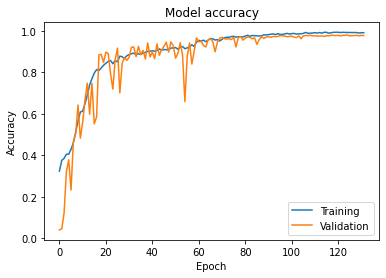

In [15]:
plt.plot(master_history.history['accuracy'])
plt.plot(master_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

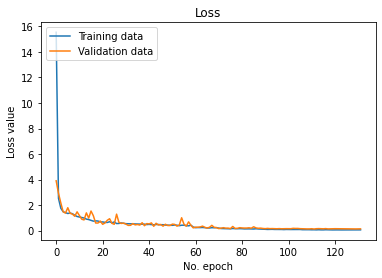

In [16]:
# Plot history: Loss
plt.plot(master_history.history['loss'], label='Training data')
plt.plot(master_history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [17]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred,axis = 1)
y_truth = np.argmax(y_test,axis = 1)
print(classification_report(y_truth, y_pred, target_names=['Healthy', 'Multi Disease','Scab', 'Rust']))

               precision    recall  f1-score   support

      Healthy       1.00      0.99      0.99       212
Multi Disease       0.74      0.77      0.75        30
         Scab       0.99      0.99      0.99       264
         Rust       0.98      0.98      0.98       223

     accuracy                           0.98       729
    macro avg       0.93      0.93      0.93       729
 weighted avg       0.98      0.98      0.98       729



In [18]:
X = []

for i in tqdm(range(n_train+1)):
    img = cv2.imread(path+'images/Test_'+str(i)+'.jpg')
    img = cv2.resize(img, (150, 150))
    X.append(img)
X = np.array(X) / 255


100%|██████████| 1821/1821 [00:57<00:00, 31.89it/s]


In [19]:
y_submit = classifier.predict(X)

In [21]:
sub = pd.read_csv(path+'sample_submission.csv')
sub.loc[:, 'healthy':] = y_submit
sub.to_csv('submission-3.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,7.689371e-08,0.000140,0.999859,3.701081e-07
1,Test_1,9.137819e-08,0.000098,0.999901,4.104424e-07
2,Test_2,1.570472e-06,0.000020,0.000003,9.999758e-01
3,Test_3,9.987068e-01,0.000268,0.000447,5.781618e-04
4,Test_4,7.143186e-08,0.000057,0.999942,3.086143e-07


## Training Using Normalised Images

In [ ]:
X = []
y = []

for i in tqdm(range(n_train+1)):
  img = cv2.imread(path+'images/Train_'+str(i)+'.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (150, 100))
  l = train_df.iloc[i][['healthy', 'multiple_diseases', 'rust', 'scab']].to_list()
  kernel = np.ones((3,3),np.float32)/9
  dst = cv2.filter2D(img,-1,kernel)
  norm = cv2.normalize(img, None, alpha=0, beta=.9, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  norm = (255*norm).astype(np.uint8)
  y.append(np.array(l))
  y.append(np.array(l))    
  X.append(cv2.flip(norm, 0))
  X.append(norm)
      
X = np.array(X) / 255
y = np.array(y)
    
  

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.20)

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(64, (5, 5), input_shape = (100, 150, 3), activation = 'relu', strides=(1,1),))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(64, (5, 5), activation = 'relu', strides=(1,1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(64, (5, 5), activation = 'relu', strides=(1,1), padding='SAME'))
classifier.add(MaxPooling2D(pool_size = (4, 4)))
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides=(1, 1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides=(1, 1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides=(1, 1), padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(MaxPooling2D(pool_size = (3, 3)))
classifier.add(Conv2D(256, (3, 3), activation = 'relu',padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(Conv2D(256, (3, 3), activation = 'relu',padding='SAME'))
classifier.add(BatchNormalization( axis= 3))
classifier.add(MaxPooling2D(pool_size = (3, 3)))
classifier.add(Flatten())
classifier.add(Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
classifier.add(Dropout(rate=0.10))
classifier.add(Dense(units = 512, activation = 'relu', kernel_regularizer=regularizers.l2(0.05)))
classifier.add(Dropout(rate=0.15))
classifier.add(Dense(units=512, activation ='relu', kernel_regularizer = regularizers.l2(0.05)))
classifier.add(Dense(units = 4, activation = 'softmax'))
classifier.summary()
classifier.compile(optimizer = Adam(learning_rate=0.003), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
master_history = classifier.fit(X_train, y_train, batch_size=32, epochs=20, validation_data= (X_test,y_test),)

initial_epoch=20
while True:
  initial_epoch = initial_epoch + 5
  end_epoch = initial_epoch+5
  history = classifier.fit(X_train, y_train, batch_size = 32, epochs = end_epoch, validation_data = (X_test,y_test), initial_epoch = initial_epoch)
  master_history.history['accuracy'].extend(history.history['accuracy'])
  master_history.history['val_accuracy'].extend(history.history['val_accuracy'])
  master_history.history['loss'].extend(history.history['loss'])
  master_history.history['val_loss'].extend(history.history['val_loss'])
  opt = int(input('Continue?: '))
  if opt == 0:
    break

In [ ]:
plt.plot(master_history.history['accuracy'])
plt.plot(master_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Plot history: Loss
plt.plot(master_history.history['loss'], label='Training data')
plt.plot(master_history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred,axis = 1)
y_truth = np.argmax(y_test,axis = 1)
print(classification_report(y_truth, y_pred, target_names=['Healthy', 'Multi Disease','Scab', 'Rust']))